In [167]:
import pandas as pd
import pandas_datareader.data as web
import pytz
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

start = datetime(2018, 3, 7)
end = datetime(2018, 4, 8)

In [2]:
def norm_twt(x):
    return 5*x

In [173]:
def download_stocks(company, start, end):
    data = pd.DataFrame()
    data = web.DataReader(company, 'morningstar', start, end)
    data['Close difference'] = data['Close'].diff()
    data['Close difference'] = data['Close difference'].fillna(0)
    data['Pct change'] = data['Close'].pct_change()
    data['Pct change'] = data['Pct change'].fillna(0)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data['Pct change'].values.reshape(-1,1))
    data['Change norm'] = data['Pct change'].map(lambda x: scaler.transform(x)[0][0])
    data['Volume change'] = data['Volume'].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
    scaler.fit(data['Volume change'].values.reshape(-1,1))
    data['Volume norm'] = data['Volume change'].map(lambda x: scaler.transform(x)[0][0])
    return data

def shift_stocks(company, num):
    global start
    global end
    start_shift = start + timedelta(days=num)
    end_shift = end + timedelta(days=num)
    data = download_stocks(company, start_shift, end_shift)
    return data


In [224]:
def remove_weekends(ls):
    wk = []
    p = 5
    for i in range(len(ls)):
        if i != p and i != (p+1):
            wk.append(ls[i])
        elif i == p+1:
            p += 7
    return wk

def format_tweets(comp):
    twt = pd.DataFrame(comp[1:-1]).reset_index()
    twt.columns = ['Date', 'Twt Score']
    twt['Date'] = twt['Date'].map(lambda x: x[1:] + ' 2018')
    twt['Date'] = twt['Date'].map(lambda x: datetime.strptime(x, '%b %d %Y'))
    twt.index = twt['Date']
    twt = twt.drop(['Date'], axis=1)
    return twt

def format_news(df):
    df.index = df['Date']
    df = df.drop(['Date'], axis=1)
    return df

def fill_zeros(col):
    col = col.replace(0, np.nan)
    col = (col.fillna(method='ffill') + col.fillna(method='bfill'))/2
    col = col.fillna(0)
    return col

In [5]:
def sse(ls1, ls2):
    sse = ls1-ls2
    sse = np.power(sse, 2)
    return sum(sse)

In [250]:
def get_accuracy(df1, df2, cat, metric):
    #df1: contains all polarities
    #df2: contains all information on the stocks 
    
    return ((df2[metric] < 0) & (df1[cat + ' Score'] < 0)) | ((df2[metric] > 0) & (df1[cat + ' Score'] > 0))

In [175]:
def plot_polarities(df1, df2, cat):
    #df1: Contains all polarity scores
    #df2: Contains all other information about stocks
    
    if cat == 'Change norm':
        title = 'Stock market movement vs Twitter and News Article sentiment polarity'
    else: 
        title = 'Stock volume movement vs Twitter and News Article sentiment polarity'
    ax = df2[cat].plot(x='Date', figsize=(15,8), title=title)
    ax.plot(df1['Twt Score'].values, label='Tesla Tweets Polarity')
    ax.plot(df1['News Score'].values, label='Tesla News Article Polarity')
    ax.legend()

In [251]:
def testing_shifts(num, df, company, metric):
    for i in range(num):
        print("Shifting by ", i)
        df_shift = shift_stocks(company, i)
        df['News Accuracy_'+ str(i)+'_'+metric] = get_accuracy(df, df_shift,'News', metric)
        df['Tweet Accuracy_'+ str(i)+'_'+metric] = get_accuracy(df, df_shift,'Twt', metric)
        print(df['Tweet Accuracy_'+ str(i)+'_'+metric].value_counts())
        print(df['News Accuracy_'+ str(i)+'_'+metric].value_counts())
        print("SSE")
        err_twt = sse(df['Twt Score'].values, df_shift[metric].values)
        print("Twitter error:", err_twt)
        err_news = sse(tsla['News Score'].values, df_shift[metric].values)
        print("News error:", err_news)

In [11]:
twt = pd.read_csv('tweets_polarity.csv', error_bad_lines=False)
twt = twt.fillna(0)
twt = twt.applymap(norm_twt)
twt.head()

,Company,Apr 08,Apr 07,Apr 06,Apr 05,Apr 04,Apr 03,Apr 02,Apr 01,Mar 31,...,Apr 11,Apr 10,Apr 09,Mar 12,Mar 11,Mar 10,Mar 09,Mar 08,Mar 07,Unnamed: 54
0,AppleAppleAppleAppleApple,0.602606,0.313283,0.435400,0.310217,0.612230,0.379209,0.011540,0.515751,0.447668,...,0.665923,0.452986,0.282538,0.572669,0.410948,1.343522,0.672740,1.153409,0.499617,0.0
1,TeslaTeslaTeslaTeslaTesla,0.507422,-0.024062,-0.141113,0.246562,0.352305,0.346709,0.124451,-0.083991,0.339742,...,0.116743,0.047549,0.615208,0.357157,0.601693,0.139915,0.515735,-0.323123,0.101691,0.0
2,Goldman SachsGoldman SachsGoldman SachsGoldman...,0.248507,0.028168,0.406970,0.623080,0.316901,-0.002742,0.556541,-0.124549,0.074586,...,0.380682,0.889525,0.161677,0.418182,0.008642,0.590873,0.199366,0.461936,0.306513,0.0
3,British PetroleumBritish PetroleumBritish Petr...,0.579459,0.379111,0.390400,1.008186,0.581854,0.036397,1.116054,0.530310,0.607970,...,0.262872,0.293403,0.491678,1.437500,0.353535,-0.041667,0.092882,0.197159,0.426304,0.0


In [80]:
aapl_twt = format_tweets(twt.iloc[0])
tsla_twt = format_tweets(twt.iloc[1])
gs_twt = format_tweets(twt.iloc[2])
bp_twt = format_tweets(twt.iloc[3])

In [95]:
news_tsla = format_news(pd.read_csv('datasets/tesla_news_data_average_scores.csv', names=['Date', 'News Score']))
news_aapl = format_news(pd.read_csv('datasets/apple_news_data_average_scores.csv', names=['Date', 'News Score']))
news_bp = format_news(pd.read_csv('datasets/bp_news_data_average_scores.csv', names=['Date', 'News Score']))
news_gs = format_news(pd.read_csv('datasets/goldman_news_data_average_scores.csv', names=['Date', 'News Score']))

## Tesla

In [97]:
news_tsla

,News Score
Date,
2018-04-10,-0.286553
2018-04-09,0.802463
2018-04-08,-0.064340
2018-04-06,-0.323022
2018-04-05,-0.437955
2018-04-04,-0.221506
2018-04-03,0.031380
2018-04-02,-0.367752
2018-03-31,-0.636518


In [227]:
tsla = download_stocks('TSLA', start, end)
tsla

Close      High       Low    Open    Volume  \
Symbol Date                                                       
TSLA   2018-03-07  332.30  332.5000  321.7400  325.44   5007297   
       2018-03-08  329.10  333.3000  326.2740  332.86   3566244   
       2018-03-09  327.17  328.4900  322.3700  324.10   5506764   
       2018-03-12  345.51  347.2100  326.5000  328.61   8264035   
       2018-03-13  341.84  345.1200  336.2635  344.92   5965805   
       2018-03-14  326.63  339.8100  323.9300  336.76   7967370   
       2018-03-15  325.60  332.8500  321.1000  329.38   6564801   
       2018-03-16  321.35  327.4000  319.0700  325.96   6117279   
       2018-03-19  313.56  320.7500  309.6700  316.50   7484294   
       2018-03-20  310.55  316.2500  308.7600  314.87   4764293   
       2018-03-21  316.53  322.4400  310.1900  310.25   5958411   
       2018-03-22  309.10  318.8200  308.1800  313.89   4939771   
       2018-03-23  301.54  311.6100  300.4500  311.25   6654899   
       2018-03-26  304.18  307.5900  291.3600  307.34   8375175   
       2018-03-27  279.18  304.2700  277.1800  304.00  13872029   
       2018-03-28  257.78  268.6800  252.1000  264.58  21001437   
       2018-03-29  266.13  270.9599  248.2100  256.49  15170749   
       2018-03-30  266.13  266.1300  266.1300  266.13         0   
       2018-04-02  252.48  260.3318  244.5901  256.26  16113968   
       2018-04-03  267.53  273.3500  254.4900  269.82  18844384   
       2018-04-04  286.94  288.3700  252.0000  252.78  19896746   
       2018-04-05  305.72  306.2600  288.2000  289.34  19121101   
       2018-04-06  299.30  309.2800  295.5000  301.00  13520286   

                   Close difference  Pct change  Change norm  Volume change  \
Symbol Date                                                                   
TSLA   2018-03-07              0.00    0.000000     0.062269       0.000000   
       2018-03-08             -3.20   -0.009630    -0.062195      -0.287791   
       2018-03-09             -1.93   -0.005864    -0.013528       0.544136   
       2018-03-12             18.34    0.056056     0.786790       0.500706   
       2018-03-13             -3.67   -0.010622    -0.075018      -0.278100   
       2018-03-14            -15.21   -0.044495    -0.512815       0.335506   
       2018-03-15             -1.03   -0.003153     0.021512      -0.176039   
       2018-03-16             -4.25   -0.013053    -0.106437      -0.068170   
       2018-03-19             -7.79   -0.024241    -0.251048       0.223468   
       2018-03-20             -3.01   -0.009599    -0.061802      -0.363428   
       2018-03-21              5.98    0.019256     0.311152       0.250639   
       2018-03-22             -7.43   -0.023473    -0.241119      -0.170958   
       2018-03-23             -7.56   -0.024458    -0.253848       0.347208   
       2018-03-26              2.64    0.008755     0.175427       0.258498   
       2018-03-27            -25.00   -0.082188    -1.000000       0.656327   
       2018-03-28            -21.40   -0.076653    -0.928459       0.513941   
       2018-03-29              8.35    0.032392     0.480930      -0.277633   
       2018-03-30              0.00    0.000000     0.062269      -1.000000   
       2018-04-02            -13.65   -0.051291    -0.600655       0.000000   
       2018-04-03             15.05    0.059609     0.832702       0.169444   
       2018-04-04             19.41    0.072553     1.000000       0.055845   
       2018-04-05             18.78    0.065449     0.908190      -0.038984   
       2018-04-06             -6.42   -0.021000    -0.209147      -0.292913   

                   Volume norm  
Symbol Date                     
TSLA   2018-03-07     0.207491  
       2018-03-08    -0.140014  
       2018-03-09     0.864530  
       2018-03-12     0.812089  
       2018-03-13    -0.128313  
       2018-03-14     0.612612  
       2018-03-15    -0.005075  
       2018-03-16     0.125176  
       2018-03-19     0.477326  
     

In [228]:
tsla = pd.merge(tsla, tsla_twt, left_index=True, right_index=True, how='left')
tsla = pd.merge(tsla, news_tsla, left_index=True, right_index=True, how='left').fillna(0)
tsla

Close      High       Low    Open    Volume  \
Symbol Date                                                       
TSLA   2018-03-07  332.30  332.5000  321.7400  325.44   5007297   
       2018-03-08  329.10  333.3000  326.2740  332.86   3566244   
       2018-03-09  327.17  328.4900  322.3700  324.10   5506764   
       2018-03-12  345.51  347.2100  326.5000  328.61   8264035   
       2018-03-13  341.84  345.1200  336.2635  344.92   5965805   
       2018-03-14  326.63  339.8100  323.9300  336.76   7967370   
       2018-03-15  325.60  332.8500  321.1000  329.38   6564801   
       2018-03-16  321.35  327.4000  319.0700  325.96   6117279   
       2018-03-19  313.56  320.7500  309.6700  316.50   7484294   
       2018-03-20  310.55  316.2500  308.7600  314.87   4764293   
       2018-03-21  316.53  322.4400  310.1900  310.25   5958411   
       2018-03-22  309.10  318.8200  308.1800  313.89   4939771   
       2018-03-23  301.54  311.6100  300.4500  311.25   6654899   
       2018-03-26  304.18  307.5900  291.3600  307.34   8375175   
       2018-03-27  279.18  304.2700  277.1800  304.00  13872029   
       2018-03-28  257.78  268.6800  252.1000  264.58  21001437   
       2018-03-29  266.13  270.9599  248.2100  256.49  15170749   
       2018-03-30  266.13  266.1300  266.1300  266.13         0   
       2018-04-02  252.48  260.3318  244.5901  256.26  16113968   
       2018-04-03  267.53  273.3500  254.4900  269.82  18844384   
       2018-04-04  286.94  288.3700  252.0000  252.78  19896746   
       2018-04-05  305.72  306.2600  288.2000  289.34  19121101   
       2018-04-06  299.30  309.2800  295.5000  301.00  13520286   

                   Close difference  Pct change  Change norm  Volume change  \
Symbol Date                                                                   
TSLA   2018-03-07              0.00    0.000000     0.062269       0.000000   
       2018-03-08             -3.20   -0.009630    -0.062195      -0.287791   
       2018-03-09             -1.93   -0.005864    -0.013528       0.544136   
       2018-03-12             18.34    0.056056     0.786790       0.500706   
       2018-03-13             -3.67   -0.010622    -0.075018      -0.278100   
       2018-03-14            -15.21   -0.044495    -0.512815       0.335506   
       2018-03-15             -1.03   -0.003153     0.021512      -0.176039   
       2018-03-16             -4.25   -0.013053    -0.106437      -0.068170   
       2018-03-19             -7.79   -0.024241    -0.251048       0.223468   
       2018-03-20             -3.01   -0.009599    -0.061802      -0.363428   
       2018-03-21              5.98    0.019256     0.311152       0.250639   
       2018-03-22             -7.43   -0.023473    -0.241119      -0.170958   
       2018-03-23             -7.56   -0.024458    -0.253848       0.347208   
       2018-03-26              2.64    0.008755     0.175427       0.258498   
       2018-03-27            -25.00   -0.082188    -1.000000       0.656327   
       2018-03-28            -21.40   -0.076653    -0.928459       0.513941   
       2018-03-29              8.35    0.032392     0.480930      -0.277633   
       2018-03-30              0.00    0.000000     0.062269      -1.000000   
       2018-04-02            -13.65   -0.051291    -0.600655       0.000000   
       2018-04-03             15.05    0.059609     0.832702       0.169444   
       2018-04-04             19.41    0.072553     1.000000       0.055845   
       2018-04-05             18.78    0.065449     0.908190      -0.038984   
       2018-04-06             -6.42   -0.021000    -0.209147      -0.292913   

                   Volume norm  Twt Score  News Score  
Symbol Date                                            
TSLA   2018-03-07     0.207491   0.101691    0.000000  
       2018-03-08    -0.140014  -0.323123    0.000000  
       2018-03-09     0.864530   0.515735    0.000000  
       2018-03-12     0.812089   0.357157    0.000000  
       2018-03-13    -0.128313  

In [229]:
tsla['News Score'] = fill_zeros(tsla['News Score'])
tsla['Twt Score'] = fill_zeros(tsla['Twt Score'])

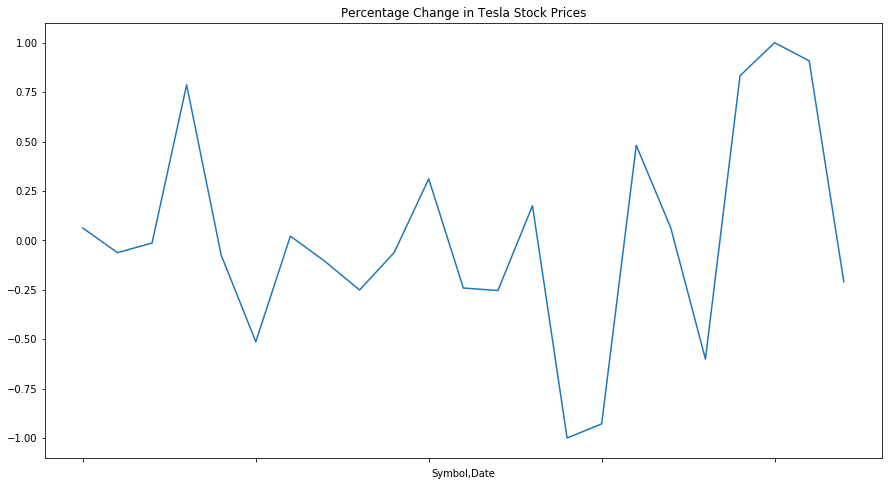

In [118]:
ax = tsla['Change norm'].plot(x='Date', figsize=(15,8), title='Percentage Change in Tesla Stock Prices')

### Unshifted

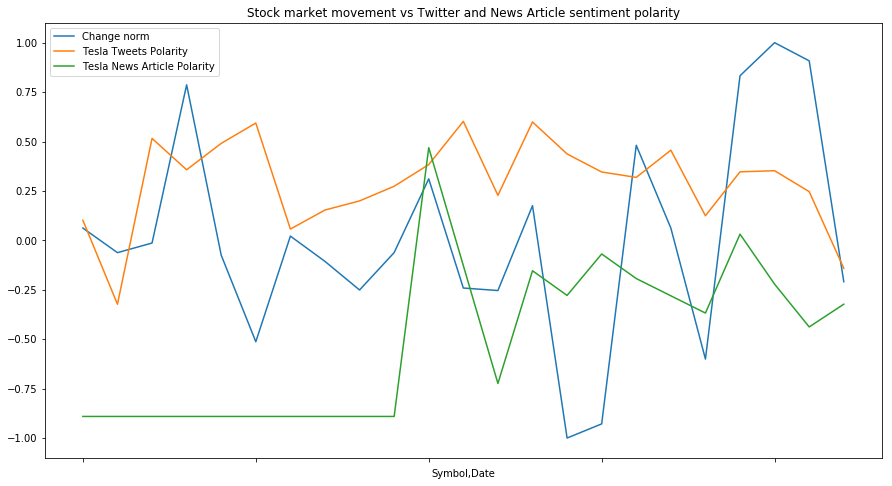

In [218]:
plot_polarities(tsla, tsla, 'Change norm')

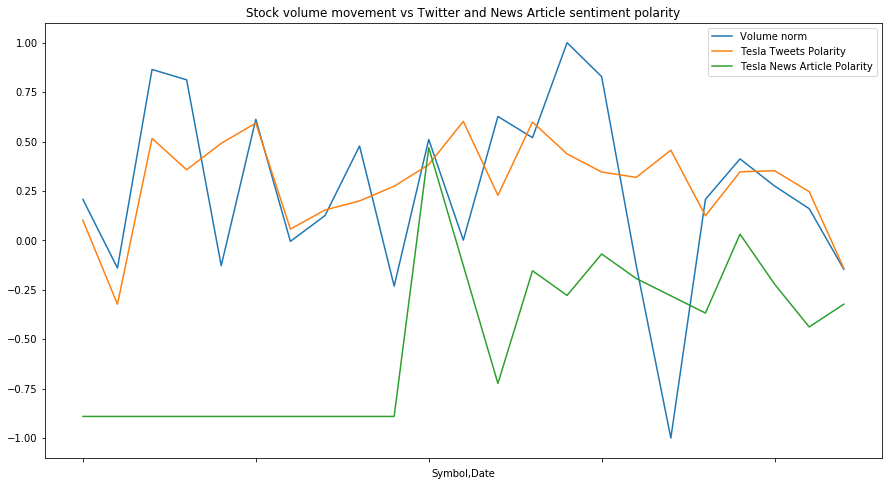

In [219]:
plot_polarities(tsla, tsla, 'Volume norm')

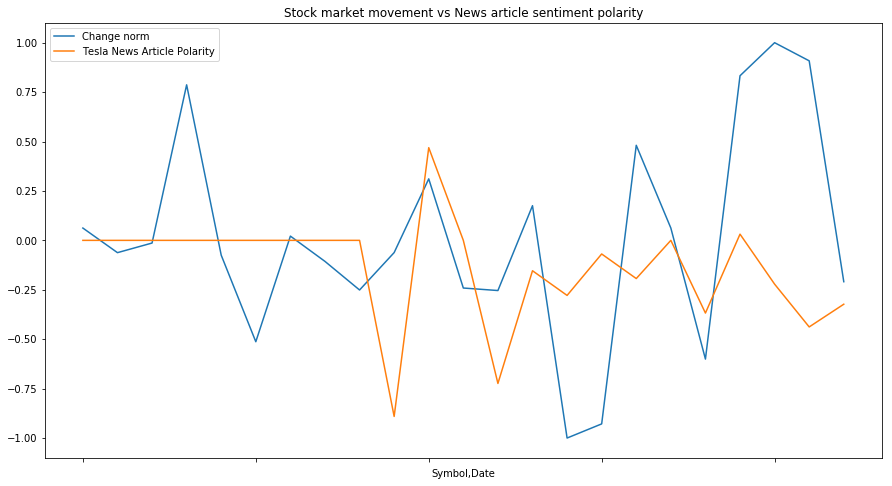

In [150]:
ax = tsla['Change norm'].plot(x='Date', figsize=(15,8), title='Stock market movement vs News article sentiment polarity')
ax.plot(tsla['News Score'].values, label='Tesla News Article Polarity')
ax.legend()

### Getting the error between sentiment scores and closing difference

### Shifted

In [252]:
testing_shifts(4, tsla, 'TSLA', 'Change norm')

Shifting by  0
True     12
False    11
Name: Tweet Accuracy_0_Change norm, dtype: int64
False    14
True      9
Name: News Accuracy_0_Change norm, dtype: int64
SSE
Twitter error: 9.08484922557
News error: 7.86952242879
Shifting by  1
False    13
True     10
Name: Tweet Accuracy_1_Change norm, dtype: int64
False    14
True      9
Name: News Accuracy_1_Change norm, dtype: int64
SSE
Twitter error: 10.18959779
News error: 9.06115518458
Shifting by  2
False    12
True     11
Name: Tweet Accuracy_2_Change norm, dtype: int64
False    14
True      9
Name: News Accuracy_2_Change norm, dtype: int64
SSE
Twitter error: 11.487931654
News error: 8.54141233548
Shifting by  3
False    13
True     10
Name: Tweet Accuracy_3_Change norm, dtype: int64
False    14
True      9
Name: News Accuracy_3_Change norm, dtype: int64
SSE
Twitter error: 10.0331118457
News error: 8.42113030618


In [253]:
testing_shifts(4, tsla, 'TSLA', 'Volume norm')

Shifting by  0
True     18
False     5
Name: Tweet Accuracy_0_Volume norm, dtype: int64
False    17
True      6
Name: News Accuracy_0_Volume norm, dtype: int64
SSE
Twitter error: 4.52988520955
News error: 8.90828797545
Shifting by  1
True     16
False     7
Name: Tweet Accuracy_1_Volume norm, dtype: int64
False    17
True      6
Name: News Accuracy_1_Volume norm, dtype: int64
SSE
Twitter error: 5.32191986575
News error: 10.8389241548
Shifting by  2
True     16
False     7
Name: Tweet Accuracy_2_Volume norm, dtype: int64
False    17
True      6
Name: News Accuracy_2_Volume norm, dtype: int64
SSE
Twitter error: 6.20896310072
News error: 9.30312443908
Shifting by  3
True     15
False     8
Name: Tweet Accuracy_3_Volume norm, dtype: int64
False    17
True      6
Name: News Accuracy_3_Volume norm, dtype: int64
SSE
Twitter error: 4.34220964285
News error: 9.141966419


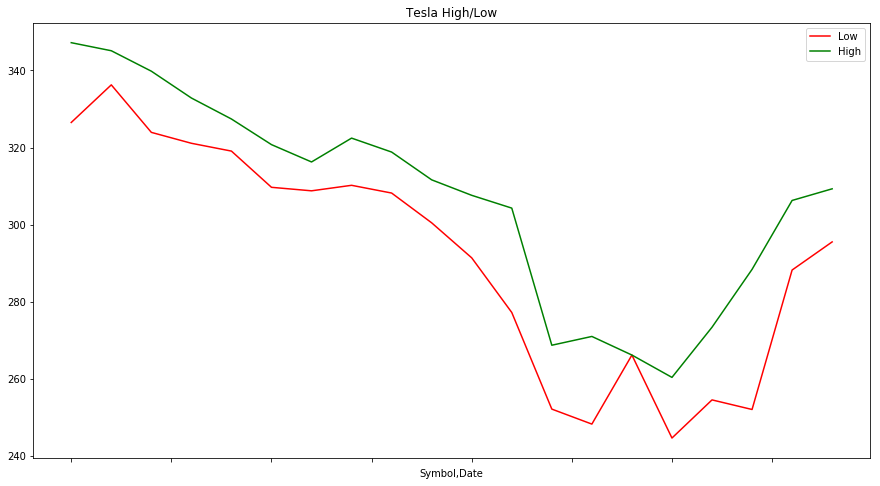

In [53]:
ax = tsla['Low'].plot(figsize=(15,8), title='Tesla High/Low', legend=True, color='red')
tsla['High'].plot(ax=ax, legend=True, color='Green')

## Apple

In [231]:
aapl = download_stocks('AAPL', start, end)
aapl

Close      High       Low     Open    Volume  \
Symbol Date                                                        
AAPL   2018-03-07  175.03  175.8500  174.2700  174.940  31703462   
       2018-03-08  176.94  177.1200  175.0700  175.480  23774107   
       2018-03-09  179.98  180.0000  177.3900  177.960  32185162   
       2018-03-12  181.72  182.3900  180.2100  180.290  32207081   
       2018-03-13  179.97  183.5000  179.2400  182.590  31693529   
       2018-03-14  178.44  180.5200  177.8100  180.320  29368356   
       2018-03-15  178.65  180.2400  178.0701  178.500  22743798   
       2018-03-16  178.02  179.1200  177.6200  178.650  39404688   
       2018-03-19  175.30  177.4700  173.6600  177.320  33446771   
       2018-03-20  175.24  176.8000  174.9400  175.240  19649350   
       2018-03-21  171.27  175.0900  171.2600  175.040  37054935   
       2018-03-22  168.85  172.6800  168.6000  170.000  41490767   
       2018-03-23  164.94  169.9200  164.9400  168.390  41028784   
       2018-03-26  172.77  173.1000  166.4400  168.070  37541236   
       2018-03-27  168.34  175.1500  166.9200  173.680  40922579   
       2018-03-28  166.48  170.0200  165.1900  167.250  41668545   
       2018-03-29  167.78  171.7500  166.9000  167.805  38398505   
       2018-03-30  167.78  167.7800  167.7800  167.780         0   
       2018-04-02  166.68  168.9400  164.4700  167.880  37586791   
       2018-04-03  168.39  168.7455  164.8800  167.640  30278046   
       2018-04-04  171.61  172.0100  164.7700  164.880  34605489   
       2018-04-05  172.80  174.2304  172.0800  172.580  26933197   
       2018-04-06  168.38  172.4800  168.2000  170.970  35005290   

                   Close difference  Pct change  Change norm  Volume change  \
Symbol Date                                                                   
AAPL   2018-03-07              0.00    0.000000    -0.298590       0.000000   
       2018-03-08              1.91    0.010912    -0.000081      -0.250110   
       2018-03-09              3.04    0.017181     0.171395       0.353791   
       2018-03-12              1.74    0.009668    -0.034129       0.000681   
       2018-03-13             -1.75   -0.009630    -0.562024      -0.015945   
       2018-03-14             -1.53   -0.008501    -0.531146      -0.073364   
       2018-03-15              0.21    0.001177    -0.266397      -0.225568   
       2018-03-16             -0.63   -0.003526    -0.395056       0.732547   
       2018-03-19             -2.72   -0.015279    -0.716552      -0.151198   
       2018-03-20             -0.06   -0.000342    -0.307953      -0.412519   
       2018-03-21             -3.97   -0.022655    -0.918308       0.885810   
       2018-03-22             -2.42   -0.014130    -0.685109       0.119710   
       2018-03-23             -3.91   -0.023157    -0.932040      -0.011135   
       2018-03-26              7.83    0.047472     1.000000      -0.085002   
       2018-03-27             -4.43   -0.025641    -1.000000       0.090070   
       2018-03-28             -1.86   -0.011049    -0.600837       0.018229   
       2018-03-29              1.30    0.007809    -0.084982      -0.078477   
       2018-03-30              0.00    0.000000    -0.298590      -1.000000   
       2018-04-02             -1.10   -0.006556    -0.477935       0.000000   
       2018-04-03              1.71    0.010259    -0.017951      -0.194450   
       2018-04-04              3.22    0.019122     0.224499       0.142923   
       2018-04-05              1.19    0.006934    -0.108902      -0.221707   
       2018-04-06             -4.42   -0.025579    -0.998295       0.299708   

                   Volume norm  
Symbol Date                     
AAPL   2018-03-07     0.060552  
       2018-03-08    -0.204702  
       2018-03-09     0.435766  
       2018-03-12     0.061275  
       2018-03-13     0.043642  
       2018-03-14    -0.017254  
       2018-03-15    -0.178674  
       2018-03-16     0.837456  
       2018-0

In [232]:
aapl = pd.merge(aapl, aapl_twt, left_index=True, right_index=True, how='left')
aapl = pd.merge(aapl, news_aapl, left_index=True, right_index=True, how='left').fillna(0)
aapl['News Score'] = fill_zeros(aapl['News Score'])
aapl['Twt Score'] = fill_zeros(aapl['Twt Score'])
aapl

Close      High       Low     Open    Volume  \
Symbol Date                                                        
AAPL   2018-03-07  175.03  175.8500  174.2700  174.940  31703462   
       2018-03-08  176.94  177.1200  175.0700  175.480  23774107   
       2018-03-09  179.98  180.0000  177.3900  177.960  32185162   
       2018-03-12  181.72  182.3900  180.2100  180.290  32207081   
       2018-03-13  179.97  183.5000  179.2400  182.590  31693529   
       2018-03-14  178.44  180.5200  177.8100  180.320  29368356   
       2018-03-15  178.65  180.2400  178.0701  178.500  22743798   
       2018-03-16  178.02  179.1200  177.6200  178.650  39404688   
       2018-03-19  175.30  177.4700  173.6600  177.320  33446771   
       2018-03-20  175.24  176.8000  174.9400  175.240  19649350   
       2018-03-21  171.27  175.0900  171.2600  175.040  37054935   
       2018-03-22  168.85  172.6800  168.6000  170.000  41490767   
       2018-03-23  164.94  169.9200  164.9400  168.390  41028784   
       2018-03-26  172.77  173.1000  166.4400  168.070  37541236   
       2018-03-27  168.34  175.1500  166.9200  173.680  40922579   
       2018-03-28  166.48  170.0200  165.1900  167.250  41668545   
       2018-03-29  167.78  171.7500  166.9000  167.805  38398505   
       2018-03-30  167.78  167.7800  167.7800  167.780         0   
       2018-04-02  166.68  168.9400  164.4700  167.880  37586791   
       2018-04-03  168.39  168.7455  164.8800  167.640  30278046   
       2018-04-04  171.61  172.0100  164.7700  164.880  34605489   
       2018-04-05  172.80  174.2304  172.0800  172.580  26933197   
       2018-04-06  168.38  172.4800  168.2000  170.970  35005290   

                   Close difference  Pct change  Change norm  Volume change  \
Symbol Date                                                                   
AAPL   2018-03-07              0.00    0.000000    -0.298590       0.000000   
       2018-03-08              1.91    0.010912    -0.000081      -0.250110   
       2018-03-09              3.04    0.017181     0.171395       0.353791   
       2018-03-12              1.74    0.009668    -0.034129       0.000681   
       2018-03-13             -1.75   -0.009630    -0.562024      -0.015945   
       2018-03-14             -1.53   -0.008501    -0.531146      -0.073364   
       2018-03-15              0.21    0.001177    -0.266397      -0.225568   
       2018-03-16             -0.63   -0.003526    -0.395056       0.732547   
       2018-03-19             -2.72   -0.015279    -0.716552      -0.151198   
       2018-03-20             -0.06   -0.000342    -0.307953      -0.412519   
       2018-03-21             -3.97   -0.022655    -0.918308       0.885810   
       2018-03-22             -2.42   -0.014130    -0.685109       0.119710   
       2018-03-23             -3.91   -0.023157    -0.932040      -0.011135   
       2018-03-26              7.83    0.047472     1.000000      -0.085002   
       2018-03-27             -4.43   -0.025641    -1.000000       0.090070   
       2018-03-28             -1.86   -0.011049    -0.600837       0.018229   
       2018-03-29              1.30    0.007809    -0.084982      -0.078477   
       2018-03-30              0.00    0.000000    -0.298590      -1.000000   
       2018-04-02             -1.10   -0.006556    -0.477935       0.000000   
       2018-04-03              1.71    0.010259    -0.017951      -0.194450   
       2018-04-04              3.22    0.019122     0.224499       0.142923   
       2018-04-05              1.19    0.006934    -0.108902      -0.221707   
       2018-04-06             -4.42   -0.025579    -0.998295       0.299708   

                   Volume norm  Twt Score  News Score  
Symbol Date                                            
AAPL   2018-03-07     0.060552   0.499617    0.430208  
       2018-03-08    -0.204702   1.153409    0.191707  
       2018-03-09     0.435766   0.672740    0.061488  
       2018-03-12     0.061275   0.572669    0.143518  
       

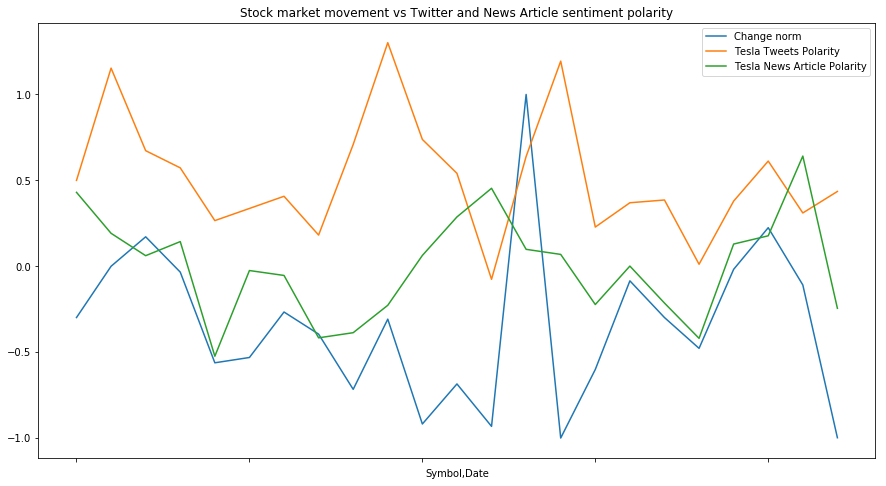

In [194]:
plot_polarities(aapl, aapl, 'Change norm')

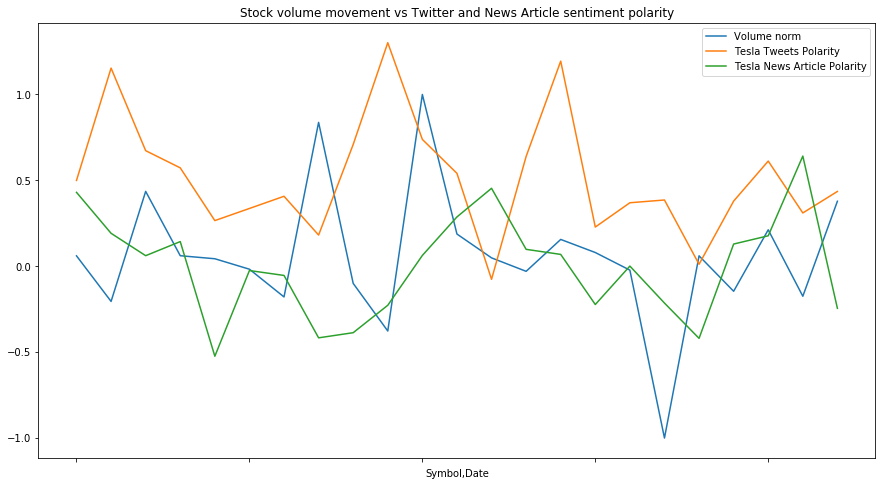

In [195]:
plot_polarities(aapl, aapl, 'Volume norm')

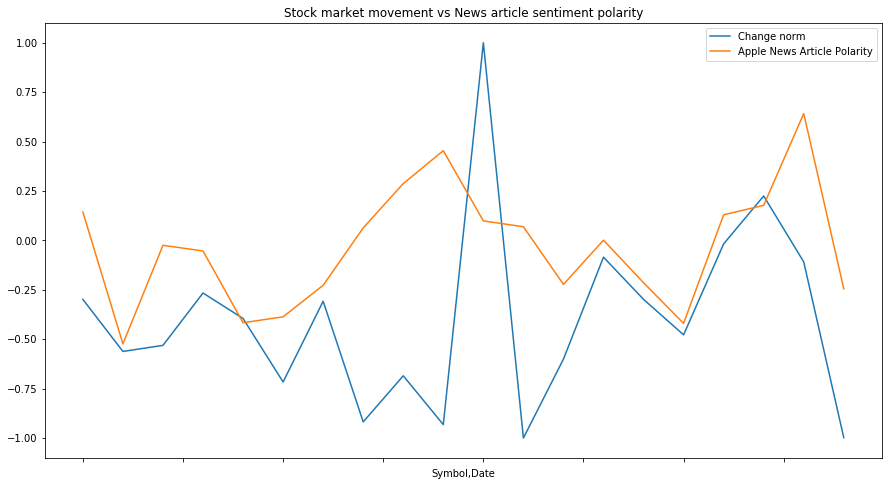

In [427]:
ax = aapl['Change norm'].plot(x='Date', figsize=(15,8), title='Stock market movement vs News article sentiment polarity')
ax.plot(news_aapl_p, label='Apple News Article Polarity')
ax.legend()

### Shifted

In [198]:
testing_shifts(4, aapl, 'AAPL')

Shifting by  0
False    19
True      4
Name: Tweet Accuracy_0, dtype: int64
True     13
False    10
Name: News Accuracy_0, dtype: int64
SSE
Twitter error: 23.4965573825
News error: 7.24816577801
Shifting by  1
False    19
True      4
Name: Tweet Accuracy_1, dtype: int64
True     13
False    10
Name: News Accuracy_1, dtype: int64
SSE
Twitter error: 26.8193817556
News error: 8.35937910995
Shifting by  2
False    20
True      3
Name: Tweet Accuracy_2, dtype: int64
True     12
False    11
Name: News Accuracy_2, dtype: int64
SSE
Twitter error: 24.9298245789
News error: 7.25278325314
Shifting by  3
False    20
True      3
Name: Tweet Accuracy_3, dtype: int64
True     12
False    11
Name: News Accuracy_3, dtype: int64
SSE
Twitter error: 25.1475623888
News error: 5.99119399423


In [254]:
testing_shifts(4, aapl, 'AAPL', 'Volume norm')

Shifting by  0
True     12
False    11
Name: Tweet Accuracy_0_Volume norm, dtype: int64
True     13
False    10
Name: News Accuracy_0_Volume norm, dtype: int64
SSE
Twitter error: 11.2784299645
News error: 3.96434253822
Shifting by  1
True     12
False    11
Name: Tweet Accuracy_1_Volume norm, dtype: int64
True     13
False    10
Name: News Accuracy_1_Volume norm, dtype: int64
SSE
Twitter error: 8.29255820478
News error: 7.03747975815
Shifting by  2
False    12
True     11
Name: Tweet Accuracy_2_Volume norm, dtype: int64
True     12
False    11
Name: News Accuracy_2_Volume norm, dtype: int64
SSE
Twitter error: 9.74484030269
News error: 6.06286188849
Shifting by  3
False    13
True     10
Name: Tweet Accuracy_3_Volume norm, dtype: int64
False    12
True     11
Name: News Accuracy_3_Volume norm, dtype: int64
SSE
Twitter error: 13.4510435061
News error: 5.00903509199


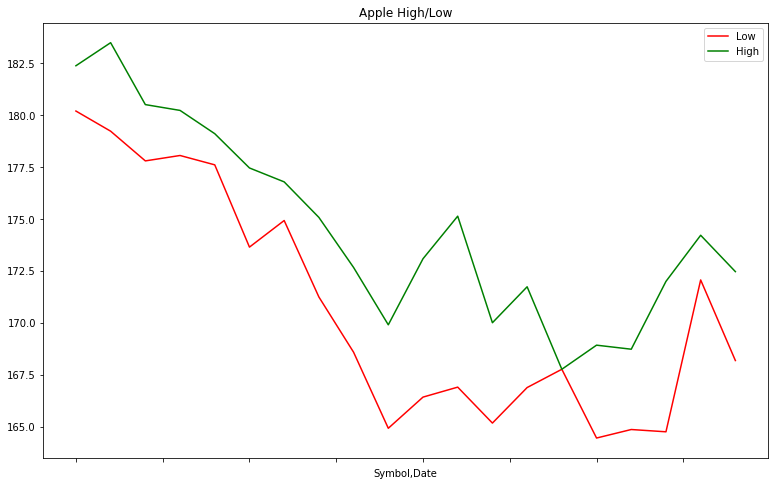

In [60]:
ax = aapl['Low'].plot(figsize=(13,8), title='Apple High/Low', legend=True, color='red')
aapl['High'].plot(ax=ax, legend=True, color='Green')

## BP

In [233]:
bp = download_stocks('BP', start, end)
bp.head()

Close    High    Low   Open   Volume  Close difference  \
Symbol Date                                                                 
BP     2018-03-07  39.31  39.600  39.05  39.31  6305276              0.00   
       2018-03-08  39.46  39.525  39.23  39.42  3177680              0.15   
       2018-03-09  39.66  39.815  39.57  39.75  3325796              0.20   
       2018-03-12  39.85  39.880  39.58  39.68  3706000              0.19   
       2018-03-13  39.55  40.200  39.46  40.08  3517855             -0.30   

                   Pct change  Change norm  Volume change  Volume norm  
Symbol Date                                                             
BP     2018-03-07    0.000000    -0.095976       0.000000     0.116297  
       2018-03-08    0.003816     0.029872      -0.496028    -0.437418  
       2018-03-09    0.005068     0.071183       0.046611     0.168329  
       2018-03-12    0.004791     0.062024       0.114320     0.243912  
       2018-03-13   -0.007528    -0.344260      -0.050768     0.059625

In [234]:
bp = pd.merge(bp, bp_twt, left_index=True, right_index=True, how='left')
bp = pd.merge(bp, news_bp, left_index=True, right_index=True, how='left').fillna(0)
bp['News Score'] = fill_zeros(bp['News Score'])
bp['Twt Score'] = fill_zeros(bp['Twt Score'])
bp

Close    High      Low   Open   Volume  Close difference  \
Symbol Date                                                                   
BP     2018-03-07  39.31  39.600  39.0500  39.31  6305276              0.00   
       2018-03-08  39.46  39.525  39.2300  39.42  3177680              0.15   
       2018-03-09  39.66  39.815  39.5700  39.75  3325796              0.20   
       2018-03-12  39.85  39.880  39.5800  39.68  3706000              0.19   
       2018-03-13  39.55  40.200  39.4600  40.08  3517855             -0.30   
       2018-03-14  38.87  39.490  38.8100  39.44  6302722             -0.68   
       2018-03-15  39.03  39.140  38.7500  38.92  3976380              0.16   
       2018-03-16  39.48  39.615  39.0700  39.11  4596504              0.45   
       2018-03-19  38.75  39.235  38.5645  39.22  4241119             -0.73   
       2018-03-20  39.04  39.185  38.6300  38.65  6005468              0.29   
       2018-03-21  40.13  40.300  39.0000  39.05  7438388              1.09   
       2018-03-22  39.03  39.600  38.9200  39.59  6243329             -1.10   
       2018-03-23  39.12  39.635  39.0910  39.26  5365647              0.09   
       2018-03-26  40.42  40.450  39.8650  40.33  6796832              1.30   
       2018-03-27  39.97  40.570  39.8100  40.52  4755929             -0.45   
       2018-03-28  39.60  40.050  39.5800  39.81  5031720             -0.37   
       2018-03-29  40.54  40.670  40.1500  40.19  8336918              0.94   
       2018-03-30  40.54  40.540  40.5400  40.54        0              0.00   
       2018-04-02  39.91  40.540  39.4500  40.53  5752852             -0.63   
       2018-04-03  40.71  40.740  40.0500  40.61  5849663              0.80   
       2018-04-04  41.03  41.030  40.5750  40.64  7305531              0.32   
       2018-04-05  41.92  42.090  41.3200  41.36  7062440              0.89   
       2018-04-06  41.76  42.390  41.5100  42.24  9060053             -0.16   

                   Pct change  Change norm  Volume change  Volume norm  \
Symbol Date                                                              
BP     2018-03-07    0.000000    -0.095976       0.000000     0.116297   
       2018-03-08    0.003816     0.029872      -0.496028    -0.437418   
       2018-03-09    0.005068     0.071183       0.046611     0.168329   
       2018-03-12    0.004791     0.062024       0.114320     0.243912   
       2018-03-13   -0.007528    -0.344260      -0.050768     0.059625   
       2018-03-14   -0.017193    -0.663023       0.791638     1.000000   
       2018-03-15    0.004116     0.039781      -0.369101    -0.295729   
       2018-03-16    0.011530     0.284275       0.155952     0.290386   
       2018-03-19   -0.018490    -0.705797      -0.077316     0.029989   
       2018-03-20    0.007484     0.150846       0.416010     0.580688   
       2018-03-21    0.027920     0.824841       0.238603     0.382648   
       2018-03-22   -0.027411    -1.000000      -0.160661    -0.063048   
       2018-03-23    0.002306    -0.019926      -0.140579    -0.040631   
       2018-03-26    0.033231     1.000000       0.266731     0.414048   
       2018-03-27   -0.011133    -0.463151      -0.300273    -0.218896   
       2018-03-28   -0.009257    -0.401274       0.057989     0.181030   
       2018-03-29    0.023737     0.686893       0.656872     0.849562   
       2018-03-30    0.000000    -0.095976      -1.000000    -1.000000   
       2018-04-02   -0.015540    -0.608499       0.000000     0.116297   
       2018-04-03    0.020045     0.565120       0.016828     0.135082   
       2018-04-04    0.007860     0.163266       0.248881     0.394122   
       2018-04-05    0.021691     0.619418      -0.033275     0.079152   
       2018-04-06   -0.003817    -0.221855       0.282850     0.432042   

                   Twt Score  News Score  
Symbol Date                               
BP     2018-03-07   0.426304   -0.759332  
       2018-03-08   0.197159   -0.090507  
       2018-03-09   

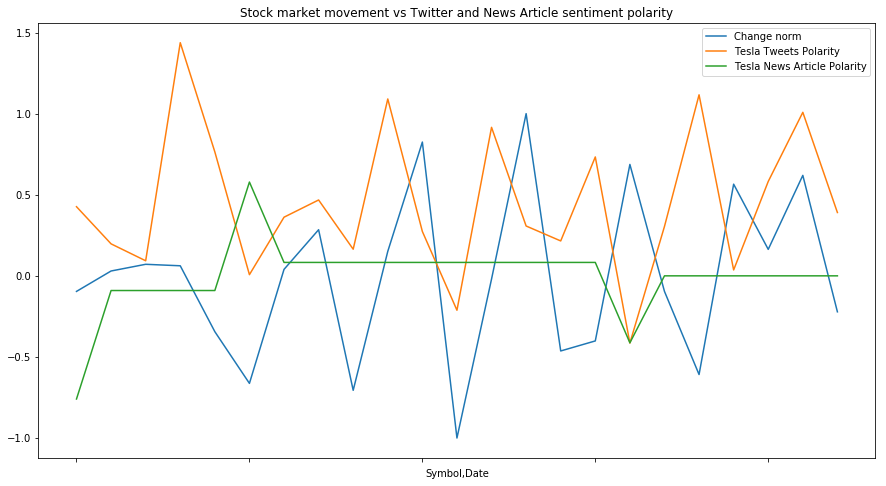

In [235]:
plot_polarities(bp, bp, 'Change norm')

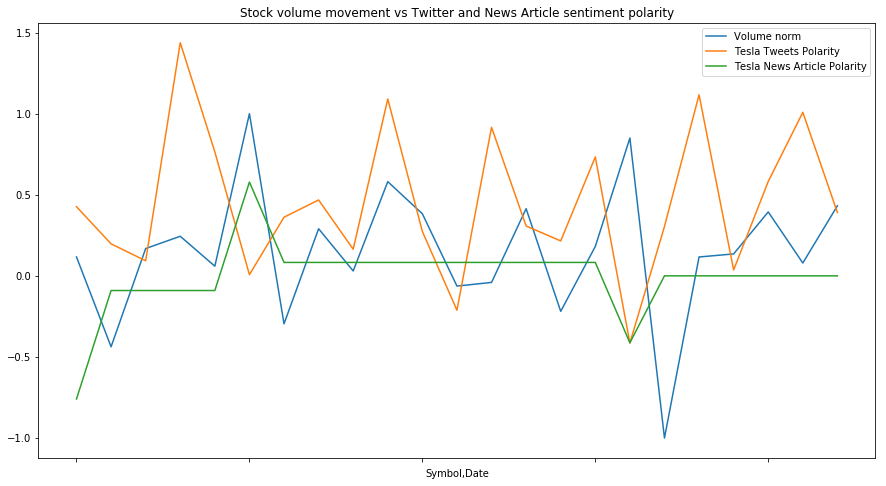

In [236]:
plot_polarities(bp, bp, 'Volume norm')

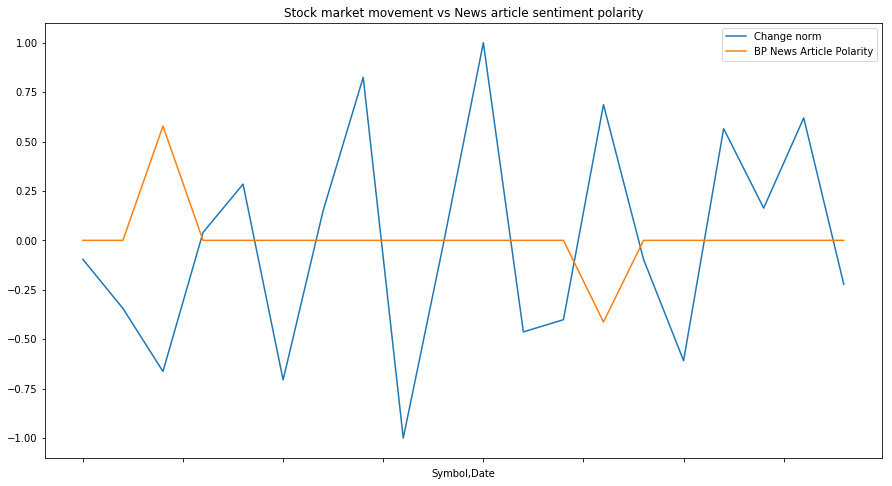

In [450]:
ax = bp['Change norm'].plot(x='Date', figsize=(15,8), title='Stock market movement vs News article sentiment polarity')
ax.plot(news_bp_p, label='BP News Article Polarity')
ax.legend()

In [240]:
testing_shifts(4, bp, 'BP')

Shifting by  0
True     12
False    11
Name: Tweet Accuracy_0, dtype: int64
False    16
True      7
Name: News Accuracy_0, dtype: int64
SSE
Twitter error: 15.0029205639
News error: 7.52969861597
Shifting by  1
False    12
True     11
Name: Tweet Accuracy_1, dtype: int64
False    16
True      7
Name: News Accuracy_1, dtype: int64
SSE
Twitter error: 12.6859606528
News error: 11.7261859943
Shifting by  2
False    13
True     10
Name: Tweet Accuracy_2, dtype: int64
False    16
True      7
Name: News Accuracy_2, dtype: int64
SSE
Twitter error: 19.9689771112
News error: 7.26374411349
Shifting by  3
False    14
True      9
Name: Tweet Accuracy_3, dtype: int64
False    16
True      7
Name: News Accuracy_3, dtype: int64
SSE
Twitter error: 12.9418942932
News error: 8.65792959929


In [255]:
testing_shifts(4, bp, 'BP', 'Volume norm')

Shifting by  0
True     17
False     6
Name: Tweet Accuracy_0_Volume norm, dtype: int64
False    15
True      8
Name: News Accuracy_0_Volume norm, dtype: int64
SSE
Twitter error: 10.8141970344
News error: 7.56760815737
Shifting by  1
True     17
False     6
Name: Tweet Accuracy_1_Volume norm, dtype: int64
False    16
True      7
Name: News Accuracy_1_Volume norm, dtype: int64
SSE
Twitter error: 6.21103493251
News error: 7.92365124779
Shifting by  2
True     16
False     7
Name: Tweet Accuracy_2_Volume norm, dtype: int64
False    16
True      7
Name: News Accuracy_2_Volume norm, dtype: int64
SSE
Twitter error: 10.7795473583
News error: 7.83483433306
Shifting by  3
True     15
False     8
Name: Tweet Accuracy_3_Volume norm, dtype: int64
False    16
True      7
Name: News Accuracy_3_Volume norm, dtype: int64
SSE
Twitter error: 11.060363239
News error: 7.01913604278


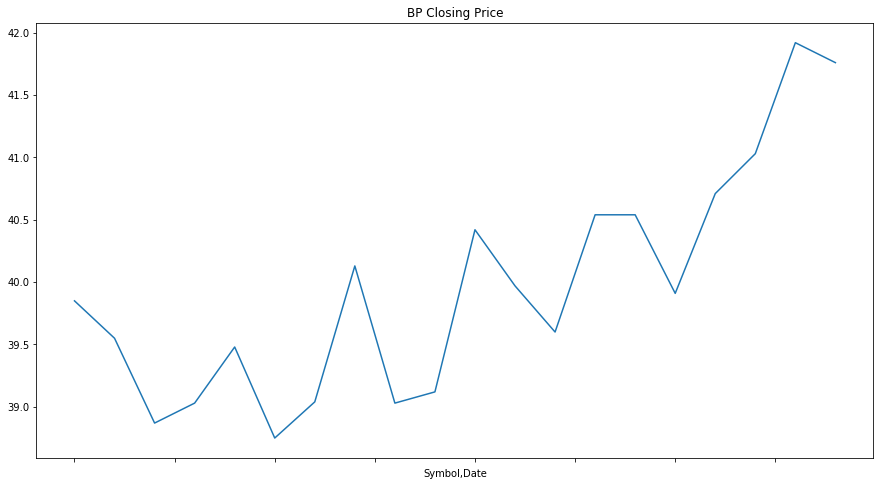

In [65]:
bp['Close'].plot(x='Date', figsize=(15,8), title='BP Closing Price')

## Goldman Sachs

In [241]:
gs = download_stocks('GS', start, end)
gs.head()

Close    High       Low    Open   Volume  \
Symbol Date                                                    
GS     2018-03-07  265.35  266.43  260.9455  262.69  2509352   
       2018-03-08  266.34  268.10  262.6300  266.48  2565359   
       2018-03-09  270.77  271.09  267.0400  268.70  4410571   
       2018-03-12  273.38  275.31  270.7700  271.00  3065557   
       2018-03-13  268.53  275.03  267.4400  274.34  2288103   

                   Close difference  Pct change  Change norm  Volume change  \
Symbol Date                                                                   
GS     2018-03-07              0.00    0.000000    -0.052289       0.000000   
       2018-03-08              0.99    0.003731     0.047804       0.022319   
       2018-03-09              4.43    0.016633     0.393936       0.719280   
       2018-03-12              2.61    0.009639     0.206310      -0.304952   
       2018-03-13             -4.85   -0.017741    -0.528240      -0.253609   

                   Volume norm  
Symbol Date                     
GS     2018-03-07     0.062862  
       2018-03-08     0.086584  
       2018-03-09     0.827357  
       2018-03-12    -0.261261  
       2018-03-13    -0.206690

In [242]:
gs = pd.merge(gs, gs_twt, left_index=True, right_index=True, how='left')
gs = pd.merge(gs, news_gs, left_index=True, right_index=True, how='left').fillna(0)
gs['News Score'] = fill_zeros(gs['News Score'])
gs['Twt Score'] = fill_zeros(gs['Twt Score'])
gs

Close     High       Low    Open   Volume  \
Symbol Date                                                     
GS     2018-03-07  265.35  266.430  260.9455  262.69  2509352   
       2018-03-08  266.34  268.100  262.6300  266.48  2565359   
       2018-03-09  270.77  271.090  267.0400  268.70  4410571   
       2018-03-12  273.38  275.310  270.7700  271.00  3065557   
       2018-03-13  268.53  275.030  267.4400  274.34  2288103   
       2018-03-14  264.43  270.780  263.9110  270.40  2478684   
       2018-03-15  266.61  269.000  265.3500  265.72  2255191   
       2018-03-16  267.60  269.850  265.3300  266.01  4114368   
       2018-03-19  262.53  267.500  259.4700  266.99  2426864   
       2018-03-20  263.19  264.640  261.8873  263.29  1514754   
       2018-03-21  261.85  266.490  260.3100  263.01  2817633   
       2018-03-22  252.60  260.820  252.1800  258.42  4489285   
       2018-03-23  245.26  254.954  244.9300  253.63  3634249   
       2018-03-26  254.88  255.360  248.4500  250.65  3787177   
       2018-03-27  247.26  257.060  245.6100  255.89  2981484   
       2018-03-28  249.37  251.230  244.3700  248.78  2660194   
       2018-03-29  251.86  252.980  248.3300  250.79  3073925   
       2018-03-30  251.86  251.860  251.8600  251.86        0   
       2018-04-02  247.35  252.600  243.7700  251.26  3429894   
       2018-04-03  250.58  250.890  245.9000  248.61  2488166   
       2018-04-04  252.62  253.220  244.5110  245.71  2853211   
       2018-04-05  255.81  258.000  253.4000  254.50  1924810   
       2018-04-06  249.97  255.340  246.6800  251.48  3621939   

                   Close difference  Pct change  Change norm  Volume change  \
Symbol Date                                                                   
GS     2018-03-07              0.00    0.000000    -0.052289       0.000000   
       2018-03-08              0.99    0.003731     0.047804       0.022319   
       2018-03-09              4.43    0.016633     0.393936       0.719280   
       2018-03-12              2.61    0.009639     0.206310      -0.304952   
       2018-03-13             -4.85   -0.017741    -0.528240      -0.253609   
       2018-03-14             -4.10   -0.015268    -0.461906       0.083292   
       2018-03-15              2.18    0.008244     0.168884      -0.090166   
       2018-03-16              0.99    0.003713     0.047331       0.824399   
       2018-03-19             -5.07   -0.018946    -0.560576      -0.410149   
       2018-03-20              0.66    0.002514     0.015156      -0.375839   
       2018-03-21             -1.34   -0.005091    -0.188880       0.860126   
       2018-03-22             -9.25   -0.035326    -1.000000       0.593282   
       2018-03-23             -7.34   -0.029058    -0.831849      -0.190462   
       2018-03-26              9.62    0.039224     1.000000       0.042080   
       2018-03-27             -7.62   -0.029896    -0.854347      -0.212742   
       2018-03-28              2.11    0.008534     0.176648      -0.107762   
       2018-03-29              2.49    0.009985     0.215592       0.155527   
       2018-03-30              0.00    0.000000    -0.052289      -1.000000   
       2018-04-02             -4.51   -0.017907    -0.532690       0.000000   
       2018-04-03              3.23    0.013058     0.298041      -0.274565   
       2018-04-04              2.04    0.008141     0.166120       0.146712   
       2018-04-05              3.19    0.012628     0.286485      -0.325388   
       2018-04-06             -5.84   -0.022829    -0.664755       0.881712   

                   Volume norm  Twt Score  News Score  
Symbol Date                                            
GS     2018-03-07     0.062862   0.306513   -0.137697  
       2018-03-08     0.086584   0.461936   -0.456834  
       2018-03-09     0.827357   0.199366   -0.119823  
       2018-03-12    -0.261261   0.418182    0.104479  
       2018-03-13    -0.206690   0.776580    0.557153  
       2018-03-14     0.15

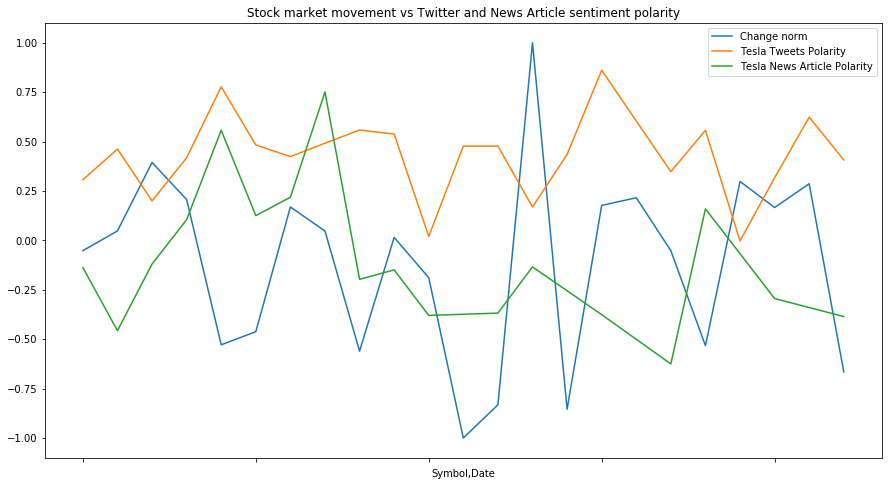

In [243]:
plot_polarities(gs, gs, 'Change norm')

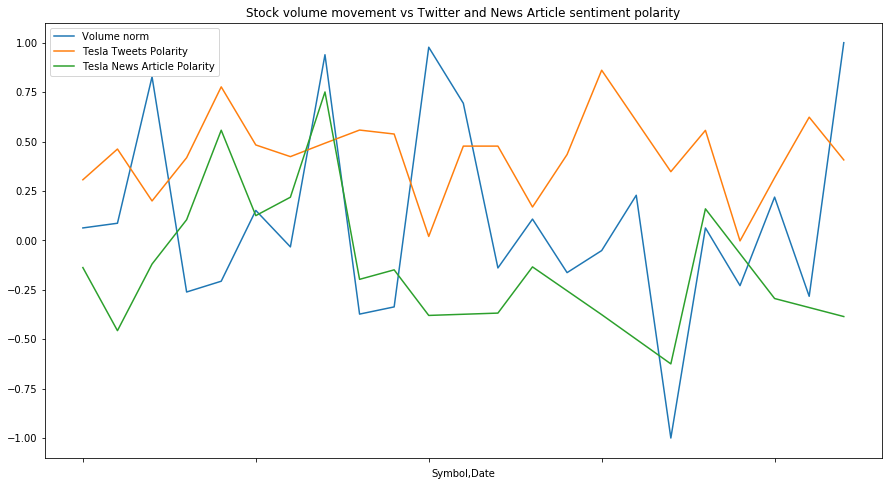

In [244]:
plot_polarities(gs, gs, 'Volume norm')

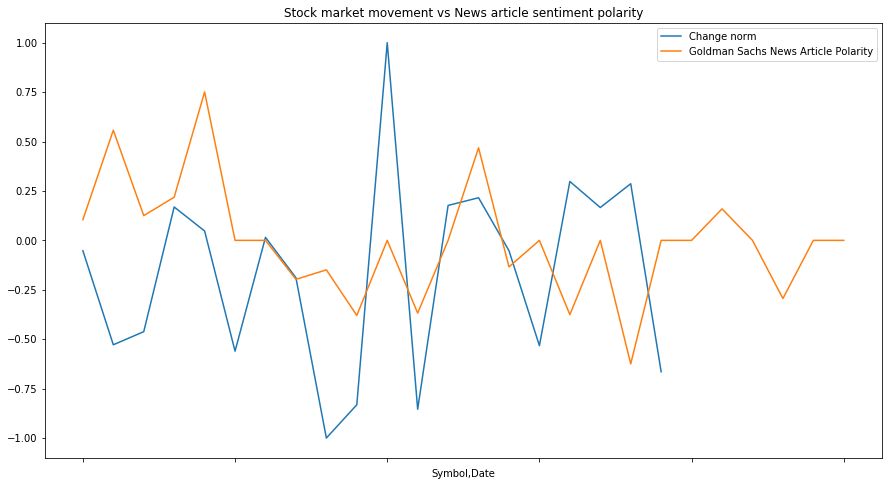

In [473]:
ax = gs['Change norm'].plot(x='Date', figsize=(15,8), title='Stock market movement vs News article sentiment polarity')
ax.plot(news_gs_p, label='Goldman Sachs News Article Polarity')
ax.legend()

In [245]:
testing_shifts(4, gs, 'GS')

Shifting by  0
False    12
True     11
Name: Tweet Accuracy_0, dtype: int64
False    12
True     11
Name: News Accuracy_0, dtype: int64
SSE
Twitter error: 14.3934061878
News error: 5.8988151458
Shifting by  1
False    13
True     10
Name: Tweet Accuracy_1, dtype: int64
False    12
True     11
Name: News Accuracy_1, dtype: int64
SSE
Twitter error: 12.2978271665
News error: 9.04859004236
Shifting by  2
False    14
True      9
Name: Tweet Accuracy_2, dtype: int64
False    12
True     11
Name: News Accuracy_2, dtype: int64
SSE
Twitter error: 12.513904863
News error: 6.19278352815
Shifting by  3
False    15
True      8
Name: Tweet Accuracy_3, dtype: int64
False    14
True      9
Name: News Accuracy_3, dtype: int64
SSE
Twitter error: 14.568220178
News error: 6.16011321849


In [256]:
testing_shifts(4, gs, 'GS', 'Volume norm')

Shifting by  0
True     13
False    10
Name: Tweet Accuracy_0_Volume norm, dtype: int64
False    12
True     11
Name: News Accuracy_0_Volume norm, dtype: int64
SSE
Twitter error: 10.14395448
News error: 6.43133125028
Shifting by  1
True     12
False    11
Name: Tweet Accuracy_1_Volume norm, dtype: int64
False    12
True     11
Name: News Accuracy_1_Volume norm, dtype: int64
SSE
Twitter error: 9.20109472467
News error: 9.30068456392
Shifting by  2
False    12
True     11
Name: Tweet Accuracy_2_Volume norm, dtype: int64
False    12
True     11
Name: News Accuracy_2_Volume norm, dtype: int64
SSE
Twitter error: 9.16315448443
News error: 8.93363815151
Shifting by  3
False    12
True     11
Name: Tweet Accuracy_3_Volume norm, dtype: int64
True     12
False    11
Name: News Accuracy_3_Volume norm, dtype: int64
SSE
Twitter error: 9.11712764024
News error: 6.12042141883


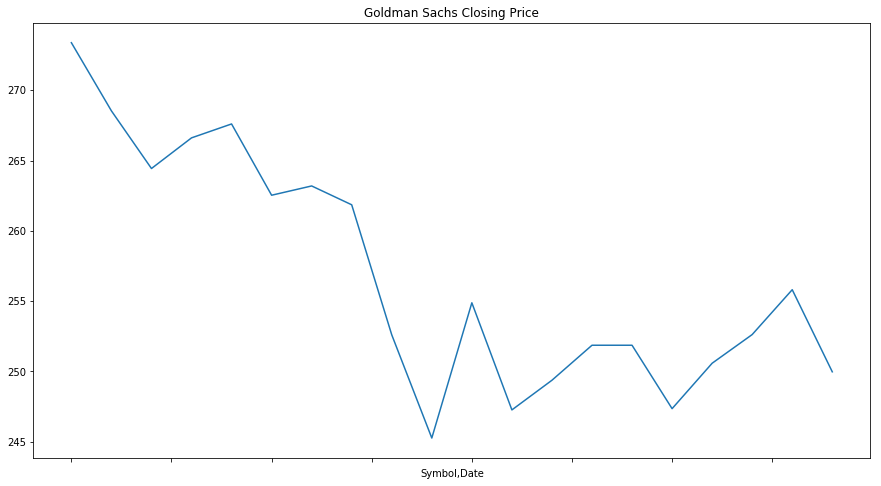

In [71]:
gs['Close'].plot(x='Date', figsize=(15,8), title='Goldman Sachs Closing Price')

## Looking at all 4 companies

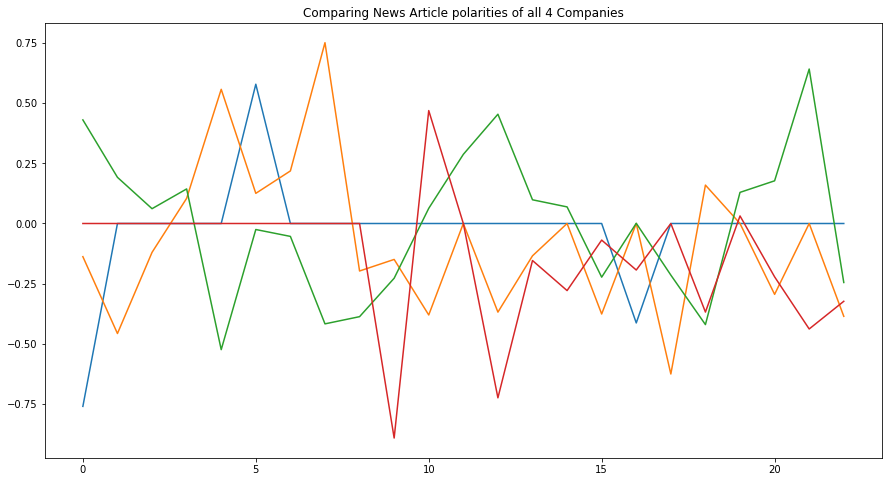

In [209]:
plt.figure(figsize=(15,8))
plt.title('Comparing News Article polarities of all 4 Companies')
plt.plot(bp['News Score'].values, label='News article polarity of BP')
plt.plot(gs['News Score'].values, label='News article polarity of Goldman Sachs')
plt.plot(aapl['News Score'].values, label='News article polarity of Apple')
plt.plot(tsla['News Score'].values, label='News article polarity of Tesla')

In [259]:
from scipy import stats

vol = [0.78, 0.57, 0.78, 0.57]
price = [0.52, 0.17, 0.52, 0.48]
stats.ttest_ind(vol, price)

Ttest_indResult(statistic=2.4243103315849353, pvalue=0.051559873901210938)

In [261]:
news_vol = [0.26, 0.57, 0.35, 0.48]
price_news = [0.65, 0.57, 0.3, 0.48]
stats.ttest_ind(news_vol, price_news)

Ttest_indResult(statistic=-0.83516826675180855, pvalue=0.43561015003025177)

In [262]:
sse_twt_price = [9.08, 23.5, 15, 14.39]
sse_twt_vol = [4.53, 11.28, 10.81, 10.14]
stats.ttest_ind(sse_twt_price, sse_twt_vol)

Ttest_indResult(statistic=1.8699991565483487, pvalue=0.11067894605427928)

In [263]:
sse_news_price = [14.74, 7.25, 7.53, 5.90]
sse_news_vol = [8.91, 3.96, 7.57, 6.43]
stats.ttest_ind(sse_news_price, sse_news_vol)

Ttest_indResult(statistic=0.94869556196899552, pvalue=0.37940403362465269)